## Project 4. Functional connectivity analysis during motor imagery using fMRI

#### Installing Packages

In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import input_data, plotting, image
import os


#### First we had to extract the files from the compressed (.tar.bz2) extension

## PART I - Compute Average Functional Connectomes

### 1. Load the files

We need to load the data (the NIFTI files for each image), the NIFTI of the atlas and the Atlas Label Locations

The current version of the code only loads one image belonging to subject 12, first scenario.

In [3]:
# Define paths (adjust these to your data location)
data_path = '/Users/joaomata/Desktop/NeuroProject/Project4/sub-12'
atlas_path = '/Users/joaomata/Desktop/NeuroProject/Schaefer_100parcels_7Networks/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz'
lut_path = '/Users/joaomata/Desktop/NeuroProject/Schaefer_100parcels_7Networks/Schaefer2018_100Parcels_7Networks_order.lut'

# Load a single subject's preprocessed fMRI data
fmri_path = '/Users/joaomata/Desktop/NeuroProject/Project4/sub-12/sub-12_ses-inside1_task-grazMI_run-01_filtered_func_data2standard.nii.gz'
fmri_img = nib.load(fmri_path)

# Load the atlas
atlas_img = nib.load(atlas_path)

### Plotting the Atlas to see the regions

The image shows teh distribution of the 100 regions of the Schaefer Atlas

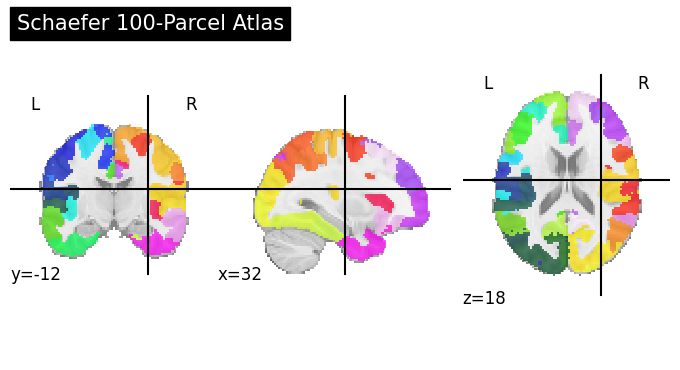

In [4]:
# Plot the atlas on a standard template
display = plotting.plot_roi(atlas_img, title="Schaefer 100-Parcel Atlas")
plt.savefig('atlas_visualization.png')
plt.show()

### Name all the 100 regions

Get the names from the .LUT file

In [5]:
import pandas as pd

def load_region_names(lut_path):
    try:
        # Load LUT file assuming space-separated values
        lut_df = pd.read_csv(lut_path, sep=r'\s+', header=None, names=['ID', 'R', 'G', 'B', 'Region'])
        
        # Ensure we have at least 100 regions
        if len(lut_df) < 100:
            raise ValueError(f"LUT file contains only {len(lut_df)} regions, expected 100.")

        return lut_df['Region'].tolist()  # Extract and return region names
    
    except Exception as e:
        print(f"Error loading LUT file: {e}")
        return [f"Region_{i+1}" for i in range(100)]  # Fallback default names

# Example usage:
region_names = load_region_names(lut_path)
print(f"Loaded {len(region_names)} regions: {region_names[:5]}")


Loaded 100 regions: ['7Networks_LH_Vis_1', '7Networks_LH_Vis_2', '7Networks_LH_Vis_3', '7Networks_LH_Vis_4', '7Networks_LH_Vis_5']


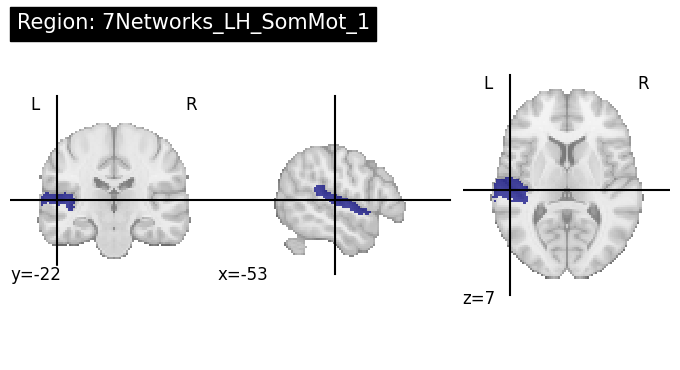

In [6]:
# Plot a specific region (e.g., region 10)
region_img = image.math_img('img == 10', img=atlas_img)
display = plotting.plot_roi(region_img, title=f"Region: {region_names[9]}")
plt.savefig('single_region_visualization.png')
plt.show()

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image('/Users/joaomata/Desktop/NeuroProject/Schaefer_100parcels_7Networks/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz')
Time series shape: (268, 100)


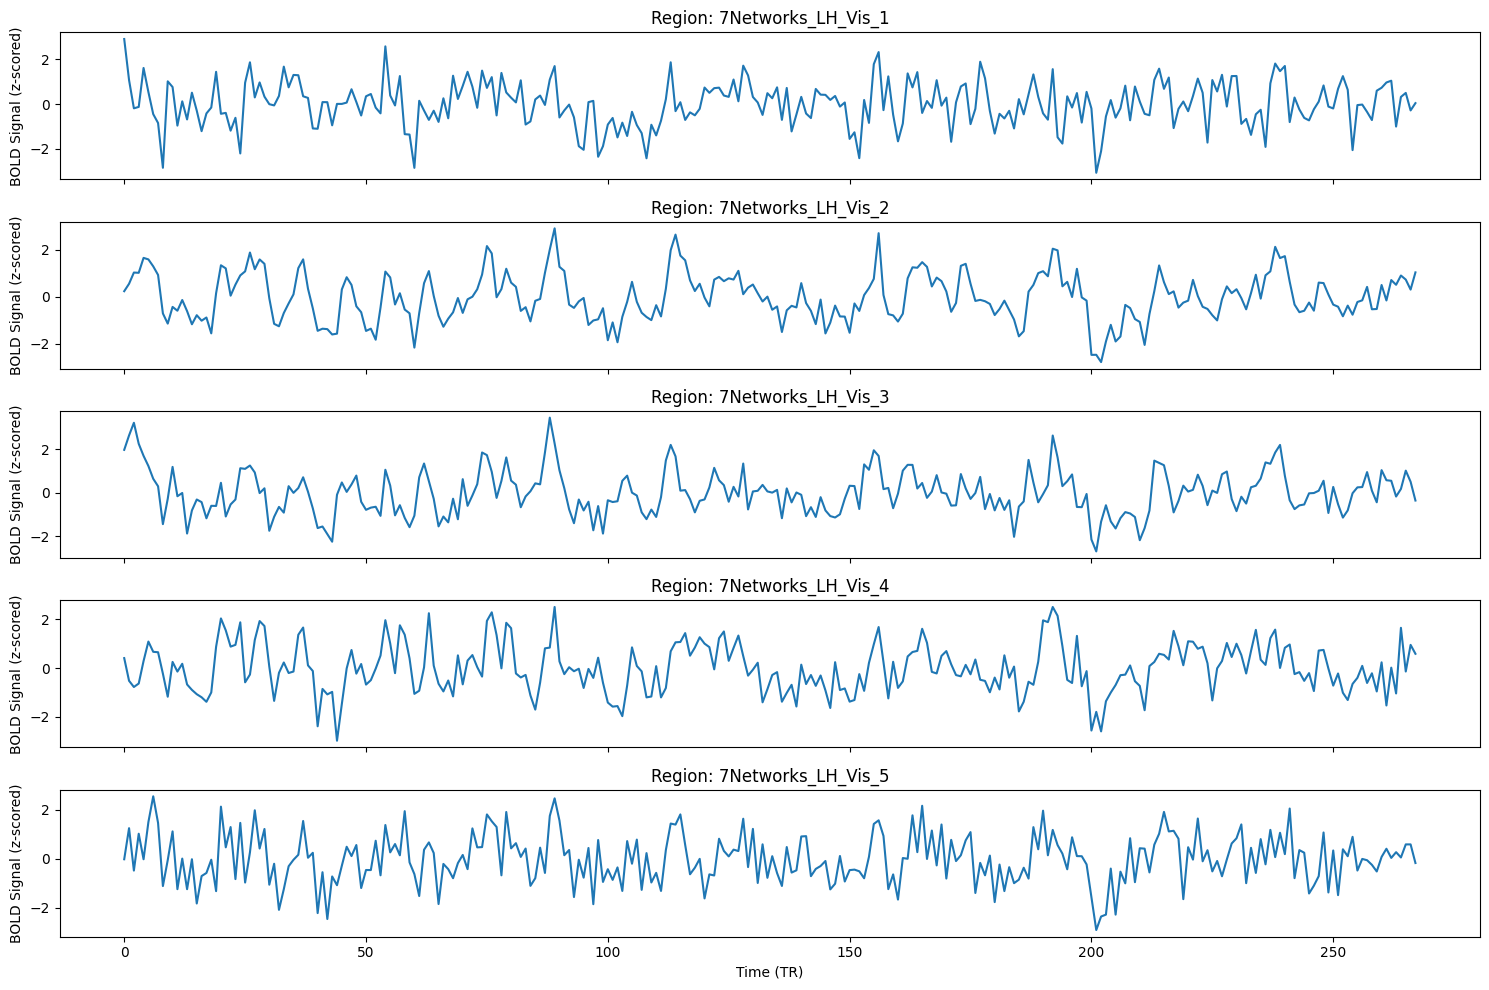

In [7]:

# Create a masker to extract time series from each region
masker = input_data.NiftiLabelsMasker(
    labels_img=atlas_img,
    standardize=True,  # Z-score normalization
    memory='nilearn_cache',  # Cache results
    verbose=1)

# Extract time series
time_series = masker.fit_transform(fmri_img)
print(f"Time series shape: {time_series.shape}")

# Plot time series for the first few regions
fig, ax = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
for i in range(5):
    if i < len(time_series[0]) and i < len(region_names):
        ax[i].plot(time_series[:, i])
        ax[i].set_title(f"Region: {region_names[i]}")
        ax[i].set_ylabel("BOLD Signal (z-scored)")

ax[-1].set_xlabel("Time (TR)")
plt.tight_layout()
plt.savefig('sample_time_series.png')
plt.show()
